In [46]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
import seaborn as sns
sns.set()

In [47]:
# set the random seed
seed = 800815
np.random.seed(seed)
N = 3
dev = qml.device("default.qubit", wires=N)

In [48]:
# Generate random state
def random_state(num_qubits, seed):
  rs = unitary_group.rvs(dim=2**num_qubits, random_state=rnd.default_rng(seed))
  return rs[0]

def random_observable(num_qubits, seed):
  real, img = rnd.random((2, 2**num_qubits, 2**num_qubits))
  
  real = real+real.T
  img = img - img.T
  
  H = real + 1j*img
  return H

H = random_observable(N, seed)

In [49]:
np.real(np.linalg.eig(H)[0])

tensor([ 8.80289681, -2.3581051 , -1.83165003, -0.9786409 ,  2.17549758,
         1.63960714,  1.20572138,  0.16142326], requires_grad=True)

In [50]:
@qml.qnode(dev, diff_method="parameter-shift")
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RZ(params[2], wires=2)
    
    qml.broadcast(qml.CNOT, wires=[0,1,2], pattern="ring")
    
    qml.RY(params[3], wires=0)
    qml.RX(params[4], wires=1)
    qml.RZ(params[5], wires=2)
    
    qml.broadcast(qml.CNOT, wires=[0,1,2], pattern="ring")
    
    return qml.expval(qml.Hermitian(H, wires=dev.wires))

In [51]:
params = np.random.random([6], requires_grad=True)

print("Params are: ", params)
print("Expectation value:", circuit(params))

Params are:  [0.93111819 0.43439045 0.1545537  0.99987185 0.47772167 0.98707036]
Expectation value: 2.575751674696278


In [52]:
x = np.matrix([[0,1],[1,0]])
y = np.matrix([[0,-1j],[1j,0]])
z = np.matrix([[1,0],[0,-1]])
i = np.eye(2)
np.linalg.eig(np.kron(y, z))

(array([ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j]),
 tensor([[-0.        -0.70710678j,  0.70710678+0.j        ,
          -0.        -0.j        , -0.        +0.j        ],
         [-0.        +0.j        ,  0.        +0.j        ,
          -0.        +0.70710678j,  0.70710678+0.j        ],
         [ 0.70710678+0.j        ,  0.        -0.70710678j,
          -0.        -0.j        , -0.        +0.j        ],
         [-0.        +0.j        ,  0.        +0.j        ,
           0.70710678+0.j        , -0.        +0.70710678j]], requires_grad=True))

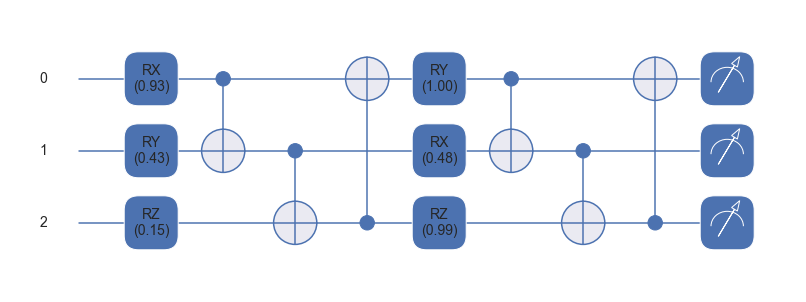

In [53]:
fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.savefig("images/circuit_1.png")
plt.show()

In [54]:
def parameter_shift_term(circuit, params, idx):
  new_params = np.copy(params)
  new_params[idx] += np.pi/2
  forward_exp = circuit(new_params)
  
  new_params[idx] -= np.pi
  backward_exp = circuit(new_params)
  
  grad = 0.5*(forward_exp - backward_exp)
  return grad

In [55]:
print(parameter_shift_term(circuit, params, 0))

1.4428470211171902


In [56]:
def parameter_shift_all(circuit, params):
  grads = np.zeros([len(params)])
  for idx, param in enumerate(params):
    grads[idx] = parameter_shift_term(circuit, params, idx)
  return grads

In [57]:
print(parameter_shift_all(circuit, params))

[ 1.44284702 -0.19947688  0.          1.08394825 -0.18399324  1.08050937]


In [58]:
grad_function = qml.grad(circuit)
print(grad_function(params)[0])

1.4428470211171898


In [59]:
def update_params(params, grads, lr=0.01):
  return params - lr*grads

Iter 0 - Expval of circuit: 0.7017980054618883
Iter 100 - Expval of circuit: -2.030687169363362
Iter 200 - Expval of circuit: -2.0833208427173036
Iter 300 - Expval of circuit: -2.0892205881258334
Iter 400 - Expval of circuit: -2.091105479576198
Iter 500 - Expval of circuit: -2.091873959612317
Iter 600 - Expval of circuit: -2.09219827872018
Iter 700 - Expval of circuit: -2.0923361442315955
Iter 800 - Expval of circuit: -2.092395019264227
Iter 900 - Expval of circuit: -2.092420292696787


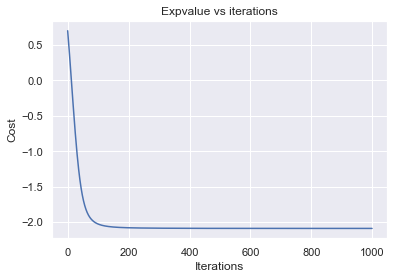

In [60]:
params = np.random.random([6], requires_grad=True)

def train(circuit, params, lr=0.01, numiters = 1000):
  costs = []
  lrs = []
  for i in range(numiters):
    prev_cost = circuit(params)
    if i%100 == 0:
      lr*=0.99
      print(f"Iter {i} - Expval of circuit: {circuit(params)}")
    grads = parameter_shift_all(circuit, params)
    params = update_params(params, grads, lr)
    curr_cost = circuit(params)
    costs.append(prev_cost)
    lrs.append(lr)
  return params, costs, lrs
new_params, costs, lrs = train(circuit, params)

plt.plot(np.arange(1000), costs)
plt.title("Expvalue vs iterations")
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.show()

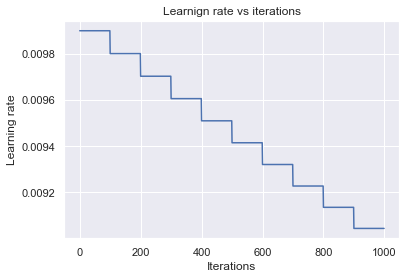

In [67]:
plt.plot(np.arange(1000), lrs)
plt.title("Learnign rate vs iterations")
plt.ylabel("Learning rate")
plt.xlabel("Iterations")
plt.show()

In [68]:
new_params

tensor([ 1.50696429, -0.57250401,  0.13329564,  0.05073803,  0.45317067,
        -0.90789832], requires_grad=True)

In [69]:
params

tensor([0.84636466, 0.59526116, 0.13329564, 0.15676431, 0.26890075,
        0.00733987], requires_grad=True)

## Research Question 1
### How good is learning when we use the 2 term param shift rule?

**Custom gate**
[How to create custom gates](https://pennylane.ai/blog/2021/05/how-to-add-custom-gates-and-templates-to-pennylane/)

In [70]:
gen = random_observable(2, seed)
eigs = np.real(np.linalg.eig(gen)[0])
max_eig = np.max(eigs)
min_eig = np.min(eigs)
print(eigs, max_eig, min_eig)

[ 5.24140552 -1.16462342  0.83405658  0.41244002] 5.241405522190654 -1.1646234222983227


In [71]:
import pennylane as qml
from pennylane.operation import Operation
from pennylane import numpy as np

class Gmu(Operation):
    num_params = 1
    num_wires = 2
    par_domain = "R"

    grad_method = "A"
    grad_recipe = None # This is the default but we write it down explicitly here.

    generator = [gen]

#     @staticmethod
#     def decomposition(theta, wires):
#         return [qml.PauliRot(theta, 'XX', wires=wires)]

In [72]:
dev2 = qml.device('default.qubit', wires=2)

@qml.qnode(dev2)
def cirq(params):
    Gmu(params[0], wires=[0, 1])
    return qml.expval(qml.PauliX(0) @ qml.PauliY(1))

cirq([0.3])

DeviceError: Gate Gmu not supported on device default.qubit.autograd

In [73]:
params = np.random.random([1], requires_grad=True)
new_params, costs, lrs = train(cirq, params, lr=0.01, numiters=5000)

plt.plot(np.arange(1000), costs)
plt.title("Expvalue vs iterations")
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.show()

DeviceError: Gate Gmu not supported on device default.qubit.autograd

In [74]:
np.linalg.eig(np.kron(z,x))

(array([ 1., -1.,  1., -1.]),
 tensor([[ 0.70710678, -0.70710678,  0.        ,  0.        ],
         [ 0.70710678,  0.70710678,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.70710678,  0.70710678],
         [ 0.        ,  0.        , -0.70710678,  0.70710678]], requires_grad=True))

### 3rd device
checking if paui rotation give good grads


In [75]:
dev3 = qml.device('default.qubit', wires=2)

@qml.qnode(dev3, diff_method="parameter-shift")
def cirq2(params):
    qml.PauliRot(params[0], "XX", wires=[0,1])
    return qml.expval(qml.PauliX(0) @ qml.PauliY(1))

cirq2([0.3])

tensor(-0.29552021, requires_grad=True)

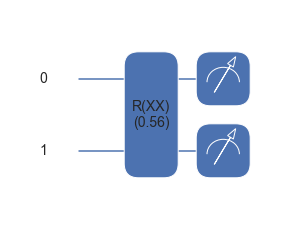

In [76]:
fig, ax = qml.draw_mpl(cirq2, decimals=2)(params)

Iter 0 - Expval of circuit: -0.5695933807867252
Iter 100 - Expval of circuit: -0.9275879282282774
Iter 200 - Expval of circuit: -0.9895722782321905
Iter 300 - Expval of circuit: -0.9985097859498958
Iter 400 - Expval of circuit: -0.9997836625496808
Iter 500 - Expval of circuit: -0.9999679963215503
Iter 600 - Expval of circuit: -0.9999951741620469
Iter 700 - Expval of circuit: -0.999999258356096
Iter 800 - Expval of circuit: -0.9999998838580876
Iter 900 - Expval of circuit: -0.9999999814701652


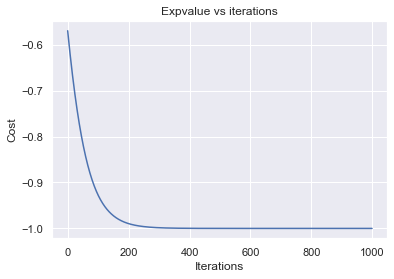

In [77]:
params = np.random.random([1], requires_grad=True)
def train(circuit, params, lr=0.01, numiters = 1000):
  costs = []
  lrs = []
  grad_function = qml.grad(circuit)
  for i in range(numiters):
    prev_cost = circuit(params)
    if i%100 == 0:
      lr*=0.99
      print(f"Iter {i} - Expval of circuit: {circuit(params)}")
    grads = np.array(grad_function(params)[0])
    params = update_params(params, grads, lr)
    curr_cost = circuit(params)
    costs.append(prev_cost)
    lrs.append(lr)
  return params, costs, lrs
new_params, costs, lrs = train(cirq2, params)

plt.plot(np.arange(1000), costs)
plt.title("Expvalue vs iterations")
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.show()

# Custom linear combination of pauli words

In [80]:
mat1 = np.kron(np.kron(np.kron(x, y),i),i)
mat2 = np.kron(np.kron(np.kron(i, y),z),i)
mat3 = np.kron(np.kron(np.kron(i, i),z),x)
mat4 = mat1-mat2+mat3
eigs = np.linalg.eig(mat4)
print(np.real(eigs[0]))

[-3.  3.  1. -3.  3.  1. -1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]


In [81]:
wires=4
devcustom1 = qml.device("default.qubit", wires=wires)
H = random_observable(wires, seed)
print(np.real(np.linalg.eig(H)[0]))
@qml.qnode(devcustom1, diff_method="backprop")
def custom_circuit(params):
  qml.PauliRot(params[0], "XY", wires=[0,1])
  qml.PauliRot(-1*params[0], "YZ", wires=[1,2])
  qml.PauliRot(params[0], "ZX", wires=[2,3])
  qml.broadcast(qml.CNOT, wires=devcustom1.wires, pattern="ring")
  qml.PauliRot(params[1], "ZX", wires=[0,1])
  qml.PauliRot(-1*params[1], "XY", wires=[1,2])
  qml.PauliRot(params[1], "XZ", wires=[2,3])
  qml.broadcast(qml.CNOT, wires=devcustom1.wires, pattern="ring")
  return qml.expval(qml.Hermitian(H, wires=devcustom1.wires))

[16.27466047  3.64021996  3.22464803 -3.70220254 -3.2348221   2.64795699
 -2.64398585 -2.35727435 -1.72817192  1.95451451  1.45424984  0.78248659
  0.40702956 -0.87536748 -0.54558381 -0.08424246]


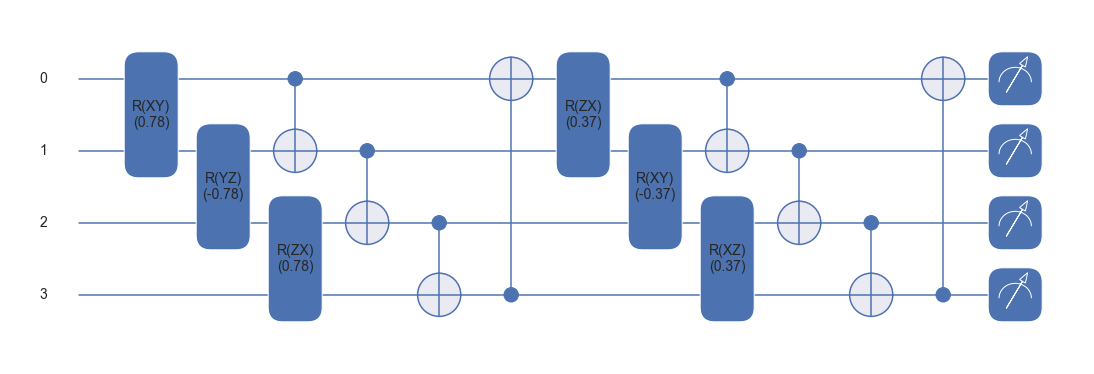

In [82]:
print()
params = np.random.random([2], requires_grad=True)
fig, ax = qml.draw_mpl(custom_circuit, decimals=2)(params)

In [117]:
def parameter_shift_term_custom(circuit, params, idx):
  new_params = np.copy(params)
  new_params[idx] += np.pi/6
  forward_exp = circuit(new_params)
  
  new_params[idx] -= np.pi/3
  backward_exp = circuit(new_params)
  
  grad = (1.5)*(forward_exp - backward_exp)
  return grad

In [118]:
def parameter_shift_all_custom(circuit, params):
  grads = np.zeros([len(params)])
  for idx, param in enumerate(params):
    grads[idx] = parameter_shift_term_custom(circuit, params, idx)
  return grads

In [119]:
def update_params(params, grads, lr=0.01):
  return params - lr*grads

In [102]:
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [95]:
p1 = np.linspace(-np.pi, np.pi, 50)
p2 = np.linspace(-np.pi, np.pi, 50)
X, Y = np.meshgrid(p1, p2)
X = np.ndarray.flatten(X)
Y = np.ndarray.flatten(Y)
Z = np.zeros(X.shape)
for i, (a, b) in tqdm(enumerate(zip(X, Y))):
  Z[i] = custom_circuit([a,b])

2500it [00:23, 105.56it/s]


In [99]:
X = X.reshape(50,50)
Y = Y.reshape(50,50)
Z = Z.reshape(50,50)


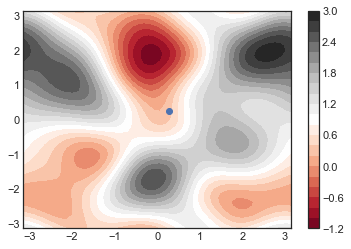

In [112]:
plt.contourf(X, Y, Z, 20, cmap='RdGy')
plt.colorbar();
plt.scatter([0.27855077], [0.24310353])

In [303]:
# params = np.random.random([2], requires_grad=True)
print(f"params {params}")
grad_function = qml.grad(custom_circuit)
print(f"real grad {grad_function(params)[0]}, real param {params}")
print(f"approx grad {parameter_shift_term_custom(custom_circuit, params, 0)}")
def trainPauliWordCirq(circuit, params, gradfuns, lr=0.1, numiters = 1000, ra="real"):
  costs = []
  lrs = []
  allapproxgrads = []
  allrealgrads = []
  grad_function = qml.grad(circuit)
  p1p2 = []
  p1p2.append(params)
  for i in range(numiters):
    prev_cost = circuit(params)
    if i%100 == 0:
      print(f"Iter {i} - Expval of circuit: {circuit(params)}")
      
    # approx grad calculation
    approxgrads = np.array([g(circuit, params, i) for i, g in enumerate(gradfuns)])
    # real grad calculation
    realgrad = grad_function(params)
    # update params
    if ra == "real":
      params = update_params(params, realgrad, lr)
    else:
      params = update_params(params, approxgrads, lr)
    curr_cost = circuit(params)
    p1p2.append(params)
    
    
    ### collect data
    costs.append(prev_cost)
    lrs.append(lr)
    allapproxgrads.append(approxgrads)
    allrealgrads.append(realgrad)
    

  return params, costs, lrs, allapproxgrads, allrealgrads, p1p2

params [0.86667073 0.00418107]
real grad 1.4682819099394748, real param [0.86667073 0.00418107]
approx grad 1.8512112361584283


In [304]:
parameter_shift_all_custom(custom_circuit, params)

tensor([ 1.85121124, -0.18720937], requires_grad=True)

In [305]:
numiters=50
new_params, costs, lrs, allapproxgrads, allrealgrads, p1p2 = trainPauliWordCirq(custom_circuit, params, 
                                                                                [parameter_shift_term_custom, parameter_shift_term_custom],
                                                                                lr=0.1, numiters=numiters, ra="approx")



Iter 0 - Expval of circuit: 1.1181534858101463


In [306]:
import seaborn as sns
sns.set()
# len(app)
green = "#209494"
orange = "#ED7D31"
red = "xkcd:brick red"
blue = "xkcd:cerulean"
pink = "xkcd:bright pink"

In [307]:
allrealgrads = np.array(allrealgrads)
allapproxgrads = np.array(allapproxgrads)
print(allrealgrads.shape, allapproxgrads.shape)
print(costs)

(50, 2) (50, 2)
[tensor(1.11815349, requires_grad=True), tensor(0.8402094, requires_grad=True), tensor(0.57848023, requires_grad=True), tensor(0.39401151, requires_grad=True), tensor(0.28794479, requires_grad=True), tensor(0.22775835, requires_grad=True), tensor(0.18557286, requires_grad=True), tensor(0.14511813, requires_grad=True), tensor(0.09608825, requires_grad=True), tensor(0.02917439, requires_grad=True), tensor(-0.06612237, requires_grad=True), tensor(-0.20014788, requires_grad=True), tensor(-0.37605917, requires_grad=True), tensor(-0.57828526, requires_grad=True), tensor(-0.77069652, requires_grad=True), tensor(-0.91889689, requires_grad=True), tensor(-1.01383923, requires_grad=True), tensor(-1.06730155, requires_grad=True), tensor(-1.09509809, requires_grad=True), tensor(-1.10884739, requires_grad=True), tensor(-1.1154111, requires_grad=True), tensor(-1.11844724, requires_grad=True), tensor(-1.1198014, requires_grad=True), tensor(-1.1203739, requires_grad=True), tensor(-1.120

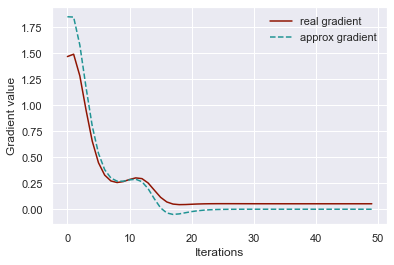

In [308]:
plt.plot(np.arange(numiters), allrealgrads[:, 0], label="real gradient", color="xkcd:brick red")
plt.plot(np.arange(numiters), allapproxgrads[:,0], label="approx gradient", color="#209494", linestyle="dashed")
plt.ylabel("Gradient value")
plt.xlabel("Iterations")
plt.legend()
plt.show()

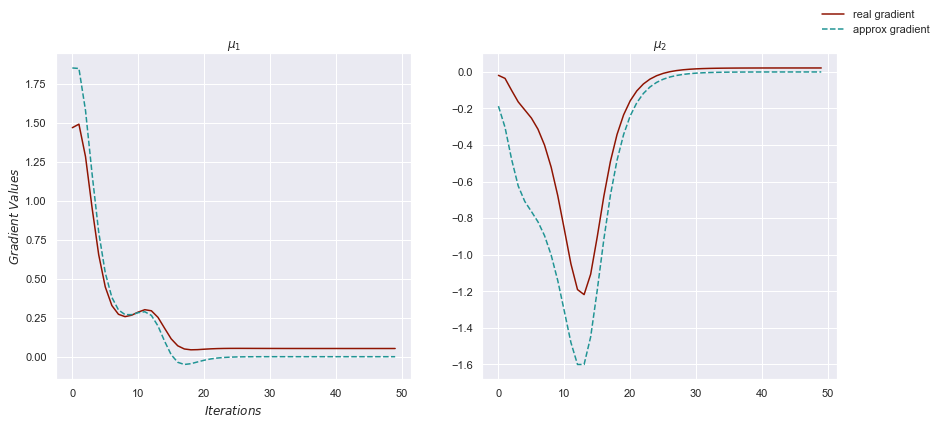

In [309]:
fig, axs = plt.subplots(1, len(params), figsize=(14, 6))
alltitles = ["$\mu_{1}$", "$\mu_{2}$", "$\mu_{3}$", "$\mu_{4}$", "$\mu_{5}$", "$\mu_{6}$"]
for i, (ax, N) in enumerate(zip(np.ndarray.flatten(axs), params)):
    # Plot cost function evaluations
    ax.plot(np.arange(numiters), allrealgrads[:, i], label="real gradient", color="xkcd:brick red")
    ax.plot(np.arange(numiters), allapproxgrads[:,i], label="approx gradient", color="#209494", linestyle="dashed")
    plt.legend
    # Axis and plot labels
    ax.set_title(f"{alltitles[i]}")

_ = axs[0].set_xlabel("$Iterations$")
_ = axs[0].set_ylabel("$Gradient$ $Values$")
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.savefig("images/fouriergrads2.svg")
plt.show()

In [268]:
print(params, new_params)

[0.86667073 0.00418107] [-0.12611898  1.88211468]


In [270]:
# (allapproxgrads[:,5])/allrealgrads[:,5]

In [271]:
np.var(np.real(eigs[0]))

tensor(3., requires_grad=True)

In [272]:
np.real(eigs[0])

tensor([-3.,  3.,  1., -3.,  3.,  1., -1., -1.,  1., -1.,  1., -1.,  1.,
        -1.,  1., -1.], requires_grad=True)

In [273]:
dot = np.dot(allrealgrads, allapproxgrads.T)
dot= np.diag(dot)
norm_realgrads = np.linalg.norm(allrealgrads, axis=1)
norm_approxgrads = np.linalg.norm(allapproxgrads, axis=1)
print(dot/(norm_realgrads*norm_approxgrads))

[ 0.99611893  0.99033292  0.97675154  0.94934534  0.91397282  0.90291026
  0.93087923  0.96299459  0.98108973  0.98983884  0.99414931  0.99620309
  0.99692591  0.9966753   0.99549385  0.99332247  0.98998776  0.98475984
  0.97571356  0.95869323  0.92517765  0.85904339  0.73683799  0.54600949
  0.31723315  0.10872682 -0.04813937 -0.15547583 -0.22646512 -0.27308764
 -0.30376866 -0.32402907 -0.33743766 -0.34631284 -0.35217509 -0.3560305
 -0.35854917 -0.36017925 -0.36122096 -0.36187537 -0.36227689 -0.36251502
 -0.36264906 -0.36271801 -0.36274732 -0.36275337 -0.36274656 -0.36273336
 -0.36271767 -0.36270176]


In [274]:
list1, list2 = zip(*p1p2)

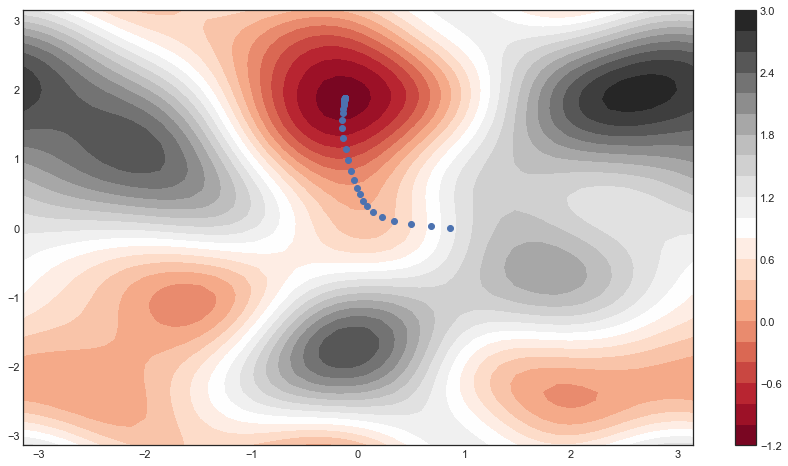

In [275]:
plt.figure(figsize=(15,8))
plt.contourf(X, Y, Z, 20, cmap='RdGy')
plt.colorbar();
plt.scatter(list1, list2)

In [276]:
new_params, costs, lrs, allapproxgrads, allrealgrads, p1p2_real = trainPauliWordCirq(custom_circuit, params, [parameter_shift_term_custom, parameter_shift_term_custom],lr=0.1, numiters=numiters)

Iter 0 - Expval of circuit: 1.1181534858101463


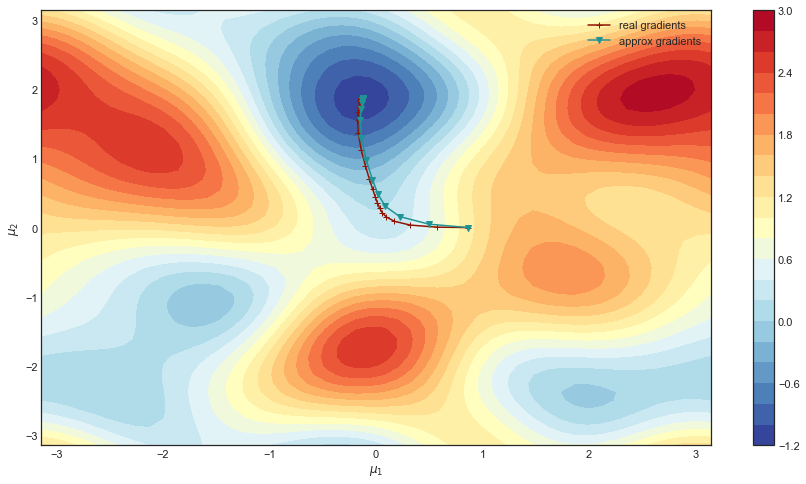

In [300]:
list12, list22 = zip(*p1p2_real)
plt.figure(figsize=(15,8))
plt.contourf(X, Y, Z, 20, cmap='RdYlBu_r')
plt.colorbar();
plt.plot(list12[::2], list22[::2], color="xkcd:brick red", label="real gradients", marker="+")
plt.plot(list1[::2], list2[::2], color="#209494", label="approx gradients", marker="v")
plt.legend()
plt.xlabel("$\mu_{1}$")
plt.ylabel("$\mu_{2}$")
plt.savefig("images/toyexpsmall.svg")
plt.show()

In [348]:
numiters=150
all_real_costs=[]
all_approx_costs=[]
for i in tqdm(range(20)):
  params = np.random.random([2], requires_grad=True)*np.pi
  new_params, approx_costs, lrs, allapproxgrads, allrealgrads, p1p2 = trainPauliWordCirq(custom_circuit, params, 
                                                                                  [parameter_shift_term_custom, parameter_shift_term_custom],
                                                                                  lr=0.1, numiters=numiters, ra="approx")
  new_params, real_costs, lrs, allapproxgrads, allrealgrads, p1p2_real = trainPauliWordCirq(custom_circuit, params, [parameter_shift_term_custom, parameter_shift_term_custom],lr=0.1, numiters=numiters)
  all_real_costs.append(real_costs)
  all_approx_costs.append(approx_costs)

  0%|                                                                                                                                                                          | 0/20 [00:00<?, ?it/s]

Iter 0 - Expval of circuit: 1.4688320805632125
Iter 100 - Expval of circuit: -1.1205548192589223
Iter 0 - Expval of circuit: 1.4688320805632125
Iter 100 - Expval of circuit: -1.121100558582672


  5%|████████                                                                                                                                                          | 1/20 [00:20<06:32, 20.68s/it]

Iter 0 - Expval of circuit: 2.5626311457103848
Iter 100 - Expval of circuit: -1.1205548192589212
Iter 0 - Expval of circuit: 2.5626311457103848
Iter 100 - Expval of circuit: -1.1211005585826714


 10%|████████████████▏                                                                                                                                                 | 2/20 [00:41<06:12, 20.68s/it]

Iter 0 - Expval of circuit: 0.6705186021560393
Iter 100 - Expval of circuit: -1.1205548192589223
Iter 0 - Expval of circuit: 0.6705186021560393
Iter 100 - Expval of circuit: -1.1211005585826723


 15%|████████████████████████▎                                                                                                                                         | 3/20 [01:01<05:49, 20.54s/it]

Iter 0 - Expval of circuit: 0.42351951260647047
Iter 100 - Expval of circuit: -1.1205548192589214
Iter 0 - Expval of circuit: 0.42351951260647047
Iter 100 - Expval of circuit: -1.121100558582673


 20%|████████████████████████████████▍                                                                                                                                 | 4/20 [01:22<05:27, 20.47s/it]

Iter 0 - Expval of circuit: 1.518287587470609
Iter 100 - Expval of circuit: -0.11919946150516586
Iter 0 - Expval of circuit: 1.518287587470609
Iter 100 - Expval of circuit: 1.2467429485845125


 25%|████████████████████████████████████████▌                                                                                                                         | 5/20 [01:42<05:05, 20.34s/it]

Iter 0 - Expval of circuit: 0.021330836922293428
Iter 100 - Expval of circuit: -1.1205548192589214
Iter 0 - Expval of circuit: 0.021330836922293428
Iter 100 - Expval of circuit: -1.1211005585826719


 30%|████████████████████████████████████████████████▌                                                                                                                 | 6/20 [02:02<04:42, 20.20s/it]

Iter 0 - Expval of circuit: 2.8120140855778746
Iter 100 - Expval of circuit: -0.11920047635057851
Iter 0 - Expval of circuit: 2.8120140855778746
Iter 100 - Expval of circuit: 1.2467006363743884


 35%|████████████████████████████████████████████████████████▋                                                                                                         | 7/20 [02:22<04:21, 20.14s/it]

Iter 0 - Expval of circuit: 2.627057522365326
Iter 100 - Expval of circuit: 0.023286505140779568
Iter 0 - Expval of circuit: 2.627057522365326
Iter 100 - Expval of circuit: 0.006269110945621437


 40%|████████████████████████████████████████████████████████████████▊                                                                                                 | 8/20 [02:42<04:01, 20.10s/it]

Iter 0 - Expval of circuit: 2.848482588183441
Iter 100 - Expval of circuit: -1.1205548192589223
Iter 0 - Expval of circuit: 2.848482588183441
Iter 100 - Expval of circuit: -1.1211005585826728


 45%|████████████████████████████████████████████████████████████████████████▉                                                                                         | 9/20 [03:02<03:42, 20.23s/it]

Iter 0 - Expval of circuit: 1.6494676365159056
Iter 100 - Expval of circuit: -0.044711026216086636
Iter 0 - Expval of circuit: 1.6494676365159056
Iter 100 - Expval of circuit: -0.051417363874770305


 50%|████████████████████████████████████████████████████████████████████████████████▌                                                                                | 10/20 [03:22<03:21, 20.13s/it]

Iter 0 - Expval of circuit: 2.761276738508099
Iter 100 - Expval of circuit: 0.023023140611213355
Iter 0 - Expval of circuit: 2.761276738508099
Iter 100 - Expval of circuit: 0.006284244300688968


 55%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11/20 [03:42<02:59, 19.92s/it]

Iter 0 - Expval of circuit: 2.377029819228812
Iter 100 - Expval of circuit: -0.044711025524598325
Iter 0 - Expval of circuit: 2.377029819228812
Iter 100 - Expval of circuit: -0.05141736387477047


 60%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12/20 [04:01<02:38, 19.85s/it]

Iter 0 - Expval of circuit: 0.8226803110308905
Iter 100 - Expval of circuit: -1.1205548192589219
Iter 0 - Expval of circuit: 0.8226803110308905
Iter 100 - Expval of circuit: -1.1211005585826717


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13/20 [04:23<02:23, 20.50s/it]

Iter 0 - Expval of circuit: 1.2331881445839952
Iter 100 - Expval of circuit: -0.044711039032892586
Iter 0 - Expval of circuit: 1.2331881445839952
Iter 100 - Expval of circuit: -0.051417363874768196


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 14/20 [14:39<20:00, 200.15s/it]

Iter 0 - Expval of circuit: 1.6121768480781578
Iter 100 - Expval of circuit: -1.1205548192589214
Iter 0 - Expval of circuit: 1.6121768480781578
Iter 100 - Expval of circuit: -1.1211005585826725


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 15/20 [14:59<12:09, 145.94s/it]

Iter 0 - Expval of circuit: 0.37325082347083255
Iter 100 - Expval of circuit: -1.1205548192589223
Iter 0 - Expval of circuit: 0.37325082347083255
Iter 100 - Expval of circuit: -1.1211005585826732


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 16/20 [15:19<07:12, 108.09s/it]

Iter 0 - Expval of circuit: -0.09548071923039014
Iter 100 - Expval of circuit: -1.120554819258921
Iter 0 - Expval of circuit: -0.09548071923039014
Iter 100 - Expval of circuit: -1.1211005585826728


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 17/20 [15:40<04:05, 81.78s/it]

Iter 0 - Expval of circuit: -0.6188408603426869
Iter 100 - Expval of circuit: -1.1205548192589223
Iter 0 - Expval of circuit: -0.6188408603426869
Iter 100 - Expval of circuit: -1.1211005585826732


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 18/20 [27:05<08:46, 263.05s/it]

Iter 0 - Expval of circuit: 1.596814534520782
Iter 100 - Expval of circuit: -1.1205548192589219
Iter 0 - Expval of circuit: 1.596814534520782
Iter 100 - Expval of circuit: -1.121100558582673


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 19/20 [27:25<03:10, 190.08s/it]

Iter 0 - Expval of circuit: -0.30181993626399495
Iter 100 - Expval of circuit: -1.1205548192589223
Iter 0 - Expval of circuit: -0.30181993626399495
Iter 100 - Expval of circuit: -1.1211005585826719


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [27:45<00:00, 83.27s/it]


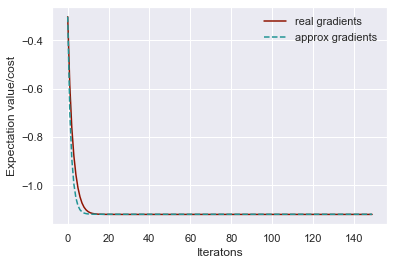

In [349]:
def mean_std(realcosts, approxcosts):
  realcosts = np.array(realcosts)
  approxcosts = np.array(approxcosts)

  real_mean = np.mean(realcosts, axis=0)
  real_std = np.std(realcosts, axis=0)
  
  approx_mean = np.mean(approxcosts, axis=0)
  approx_std = np.std(approxcosts, axis=0)
  return real_mean, real_std, approx_mean, approx_std
plt.plot(real_costs, color="xkcd:brick red", label="real gradients")
plt.plot(approx_costs, color=green, linestyle="dashed", label="approx gradients")
plt.xlabel("Iteratons")
plt.ylabel("Expectation value/cost")
plt.legend()
plt.savefig("images/toyCostComparison.svg")
plt.show()

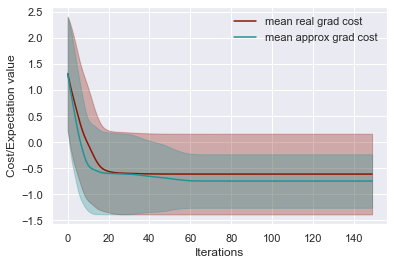

In [352]:
real_mean, real_std, approx_mean, approx_std = mean_std(all_real_costs, all_approx_costs)

plt.plot(real_mean, color="xkcd:brick red", label="mean real grad cost")
plt.fill_between(np.arange(numiters), real_mean-real_std, real_mean+real_std, color="xkcd:brick red", alpha=0.3)

plt.plot(approx_mean, color=green, label="mean approx grad cost")
plt.fill_between(np.arange(numiters), approx_mean-approx_std, approx_mean+approx_std, color=green, alpha=0.3)
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Cost/Expectation value")
plt.savefig("images/toytwomeanstd.svg")
plt.show()

In [ ]:
np.min(all_real_costs)